In [10]:
import optuna
import pandas as pd
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import time
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


In [11]:
# === PATHS ===
SCRIPT_PATH = os.getcwd()
DATA_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', 'data', 'preprocessed', 'decision_tree'))
MODELS_DIR = os.path.abspath(os.path.join(SCRIPT_PATH, '..', 'models','decision_tree'))
FEATURES_NAMES_DIR = os.path.abspath(os.path.join(DATA_DIR,'feature_names.pkl'))
os.makedirs(MODELS_DIR, exist_ok=True)

# Load preprocessed data
train_data = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
#val_data = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# Load feature names from saved file
feature_cols = joblib.load(FEATURES_NAMES_DIR)


In [12]:
# Prepare features and labels
X_train = train_data[feature_cols]
y_train = train_data['Fault_Condition']
#X_val = val_data[feature_cols]
#y_val = val_data['Fault_Condition']
X_test = test_data[feature_cols]
y_test = test_data['Fault_Condition']

# Global dictionary for optimization results
results = {}

In [13]:
# Train Random Forest model with optimized parameters by optuna
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth    = trial.suggest_int("max_depth", 5, 20)
    min_split    = trial.suggest_int("min_samples_split", 2, 10)
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_split,
        random_state=42,
        n_jobs=-1
    )
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')

    return np.mean(scores)




In [14]:
start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
t_optuna = time.time() - start

acc_optuna = study.best_value
best_trial = study.best_trial.number

print("Optuna:", study.best_params, "Acc:", acc_optuna, "Time:", round(t_optuna,2),"s")


[I 2025-10-23 12:09:10,360] A new study created in memory with name: no-name-ea14ddd0-4f8c-4f82-9ca6-f6fd2cb607ef
[I 2025-10-23 12:09:10,741] Trial 0 finished with value: 0.952923076923077 and parameters: {'n_estimators': 54, 'max_depth': 19, 'min_samples_split': 3}. Best is trial 0 with value: 0.952923076923077.
[I 2025-10-23 12:09:11,546] Trial 1 finished with value: 0.952923076923077 and parameters: {'n_estimators': 159, 'max_depth': 6, 'min_samples_split': 8}. Best is trial 0 with value: 0.952923076923077.
[I 2025-10-23 12:09:12,306] Trial 2 finished with value: 0.952923076923077 and parameters: {'n_estimators': 151, 'max_depth': 8, 'min_samples_split': 7}. Best is trial 0 with value: 0.952923076923077.
[I 2025-10-23 12:09:13,034] Trial 3 finished with value: 0.952923076923077 and parameters: {'n_estimators': 145, 'max_depth': 12, 'min_samples_split': 8}. Best is trial 0 with value: 0.952923076923077.
[I 2025-10-23 12:09:13,394] Trial 4 finished with value: 0.9452307692307693 and p

Optuna: {'n_estimators': 54, 'max_depth': 19, 'min_samples_split': 3} Acc: 0.952923076923077 Time: 13.25 s


In [15]:
best_model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Test Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

      faulty       1.00      1.00      1.00        14
  faulty_zip       1.00      1.00      1.00        14
     healthy       1.00      0.86      0.92        14
 healthy_zip       0.88      1.00      0.93        14

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56



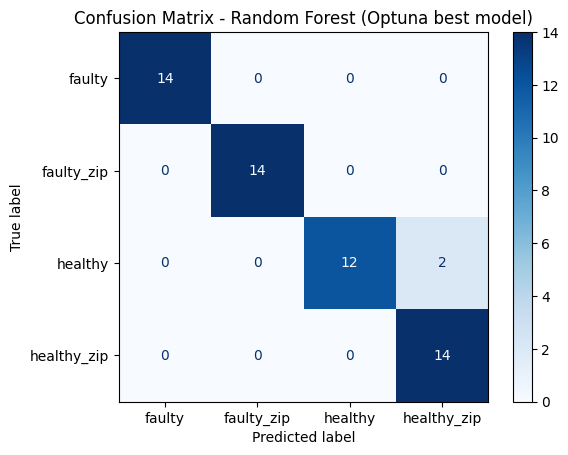

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Random Forest (Optuna best model)")
plt.show()

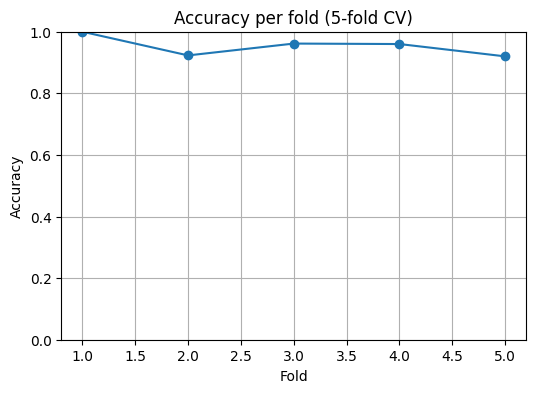

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
fold_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

plt.figure(figsize=(6,4))
plt.plot(range(1, 6), fold_scores, marker='o')
plt.title("Accuracy per fold (5-fold CV)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

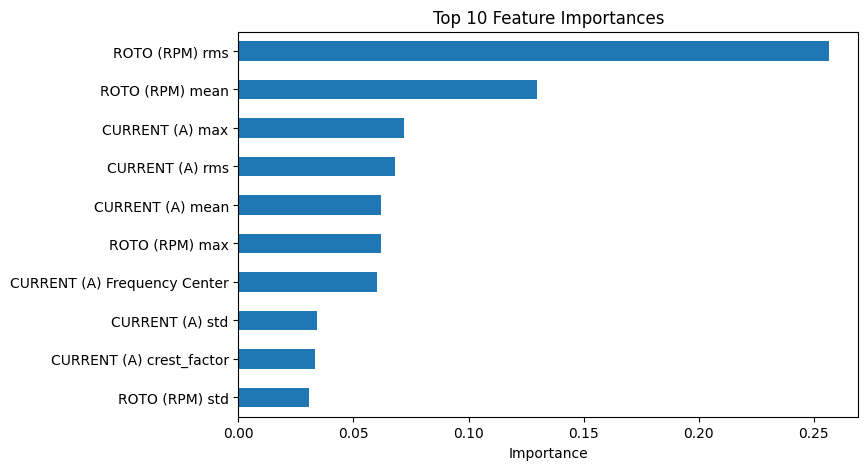

In [18]:
importances = pd.Series(best_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

In [19]:
# Save the trained model
MODEL_PATH = os.path.join(MODELS_DIR, 'random_forest.pkl')
joblib.dump(best_model, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")


Model saved to: C:\Users\Jakub\Kuba_lokalne\studia\Praca_magisterska\Projekt\Fault-detection-in-mechanical-devices\models\decision_tree\random_forest.pkl
